In [1]:
import h5py
from pathlib import Path
import numpy as np
import pandas as pd
import spatialdata as sd

/srv/scratch/benjaminr/anaconda3/envs/ghent_hackathon_mixed/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/srv/scratch/benjaminr/anaconda3/envs/ghent_hackathon_mixed/lib/python3.10/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
pancreas = Path('../data/imcdatasets/Damond_2019_Pancreas')
assert pancreas.exists(), pancreas

In [3]:
sdata = sd.SpatialData()

for mask in pancreas.glob('masks/*.h5'):
    with h5py.File(mask, 'r') as f:
        keys = f.keys()
        print(keys)
        k_mask = list(keys)[0]
        mask = np.array(f[k_mask]).astype(int)
        print(mask.shape)
        el = sd.models.Labels2DModel.parse(mask, transformations={
            k_mask: sd.transformations.Identity()
        })
        print(el)
        sdata.add_labels(k_mask, el)
    break


<KeysViewHDF5 ['E02']>
(645, 439)
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                
<xarray.SpatialImage 'image' (y: 645, x: 439)>
dask.array<array, shape=(645, 439), dtype=int64, chunksize=(645, 439), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 640.5 641.5 642.5 643.5 644.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 434.5 435.5 436.5 437.5 438.5
Attributes:
    transform:  {'E02': Identity }


In [4]:
for image in pancreas.glob('images/*.h5'):
    with h5py.File(image, 'r') as f:
        keys = f.keys()
        k_dimnames = [k for k in keys if k.endswith('_dimnames')][0]
        k_img = [k for k in keys if not k.endswith('_dimnames')][0]
        img = np.array(f[k_img])
        print(img.shape)
        print(f[k_dimnames])
        dims = np.array(f[k_dimnames]['3']).astype(str)
        print(list(dims))

        el = sd.models.Image2DModel.parse(img, c_coords=dims, transformations={
            k_img: sd.transformations.Identity()
        })
        print(el)
        sdata.add_image(k_img + '_image', el)
    break
sdata

(38, 645, 439)
<HDF5 group "/.E02_dimnames" (1 members)>
['H3', 'SMA', 'INS', 'CD38', 'CD44', 'PCSK2', 'CD99', 'CD68', 'MPO', 'SLC2A1', 'CD20', 'AMY2A', 'CD3e', 'PPY', 'PIN', 'PD_1', 'GCG', 'PDX1', 'SST', 'SYP', 'KRT19', 'CD45', 'FOXP3', 'CD45RA', 'CD8a', 'CA9', 'IAPP', 'Ki67', 'NKX6_1', 'p_HH3', 'CD4', 'CD31', 'CDH1', 'PTPRN', 'p_Rb', 'cPARP_cCASP3', 'DNA1', 'DNA2']
INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
<xarray.SpatialImage 'image' (c: 38, y: 645, x: 439)>
dask.array<array, shape=(38, 645, 439), dtype=float64, chunksize=(38, 645, 439), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U12 'H3' 'SMA' 'INS' 'CD38' ... 'cPARP_cCASP3' 'DNA1' 'DNA2'
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 640.5 641.5 642.5 643.5 644.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 434.5 435.5 436.5 437.5 438.5
Attributes:
    transform:  {'E02': Identity }


SpatialData object with:
├── Images
│     └── 'E02_image': SpatialImage[cyx] (38, 645, 439)
└── Labels
      └── 'E02': SpatialImage[yx] (645, 439)
with coordinate systems:
▸ 'E02', with elements:
        E02_image (Images), E02 (Labels)

In [5]:
import anndata as ad

adata = ad.read_h5ad(pancreas / 'sce.h5ad')
adata

AnnData object with n_obs × n_vars = 252059 × 38
    obs: 'cell_id', 'image_name', 'image_number', 'cell_number', 'cell_type', 'cell_category', 'cell_x', 'cell_y', 'cell_area', 'cell_number_absolute', 'neighbors_number', 'islet_parent', 'islet_closest', 'distance_to_islet', 'distance_to_bloodvessel', 'image_width', 'image_height', 'image_filename', 'tissue_slide', 'tissue_region', 'patient_id', 'patient_batch', 'patient_stage', 'patient_disease_duration', 'patient_age', 'patient_gender', 'patient_ethnicity', 'patient_BMI'
    var: 'channel', 'metal', 'name', 'short_name', 'antibody_clone', 'full_name'
    layers: 'exprs', 'quant_norm'

In [6]:
adata.obs.astype({
    'cell_type': 'category',
})

,cell_id,image_name,image_number,cell_number,cell_type,cell_category,cell_x,cell_y,cell_area,cell_number_absolute,...,tissue_slide,tissue_region,patient_id,patient_batch,patient_stage,patient_disease_duration,patient_age,patient_gender,patient_ethnicity,patient_BMI
138_1,138_1,E02,138,1,acinar,exocrine,84.062500,1.281250,32,1,...,E,Tail,6126,1,Non-diabetic,NaN,25.2,M,Caucasian,25.1
138_2,138_2,E02,138,2,ductal,exocrine,140.266667,0.466667,15,2,...,E,Tail,6126,1,Non-diabetic,NaN,25.2,M,Caucasian,25.1
138_3,138_3,E02,138,3,ductal,exocrine,217.476190,1.976190,42,3,...,E,Tail,6126,1,Non-diabetic,NaN,25.2,M,Caucasian,25.1
138_4,138_4,E02,138,4,ductal,exocrine,321.880952,2.928571,42,4,...,E,Tail,6126,1,Non-diabetic,NaN,25.2,M,Caucasian,25.1
138_5,138_5,E02,138,5,ductal,exocrine,312.787234,2.489362,47,5,...,E,Tail,6126,1,Non-diabetic,NaN,25.2,M,Caucasian,25.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319_1146,319_1146,J34,319,1146,ductal,exocrine,69.104651,332.616279,86,252055,...,J,Tail,6180,2,Long-duration,11.0,27.0,M,Caucasian,25.9
319_1147,319_1147,J34,319,1147,ductal,exocrine,120.586207,333.586207,29,252056,...,J,Tail,6180,2,Long-duration,11.0,27.0,M,Caucasian,25.9
319_1148,319_1148,J34,319,1148,ductal,exocrine,128.821918,332.561644,73,252057,...,J,Tail,6180,2,Long-duration,11.0,27.0,M,Caucasian,25.9
319_1149,319_1149,J34,319,1149,acinar,exocrine,271.595238,333.416667,84,252058,...,J,Tail,6180,2,Long-duration,11.0,27.0,M,Caucasian,25.9


In [7]:
adata.obs.dtypes

cell_id                      object
image_name                   object
image_number                  int32
cell_number                   int32
cell_type                    object
cell_category                object
cell_x                      float64
cell_y                      float64
cell_area                     int32
cell_number_absolute          int32
neighbors_number            float64
islet_parent                  int32
islet_closest                 int32
distance_to_islet           float64
distance_to_bloodvessel     float64
image_width                   int32
image_height                  int32
image_filename               object
tissue_slide                 object
tissue_region                object
patient_id                    int32
patient_batch                 int32
patient_stage                object
patient_disease_duration    float64
patient_age                 float64
patient_gender               object
patient_ethnicity            object
patient_BMI                 

In [8]:
adata.obs = adata.obs.astype({
    'cell_type': 'category',
})
adata.obs.dtypes

cell_id                       object
image_name                    object
image_number                   int32
cell_number                    int32
cell_type                   category
cell_category                 object
cell_x                       float64
cell_y                       float64
cell_area                      int32
cell_number_absolute           int32
neighbors_number             float64
islet_parent                   int32
islet_closest                  int32
distance_to_islet            float64
distance_to_bloodvessel      float64
image_width                    int32
image_height                   int32
image_filename                object
tissue_slide                  object
tissue_region                 object
patient_id                     int32
patient_batch                  int32
patient_stage                 object
patient_disease_duration     float64
patient_age                  float64
patient_gender                object
patient_ethnicity             object
p

In [9]:
table = sd.models.TableModel.parse(adata[adata.obs['image_name'] == 'E02', :].copy(), region_key='image_name', instance_key='cell_number', region=sdata.coordinate_systems)
table

/srv/scratch/benjaminr/anaconda3/envs/ghent_hackathon_mixed/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/srv/scratch/benjaminr/anaconda3/envs/ghent_hackathon_mixed/lib/python3.10/site-packages/spatialdata/models/models.py:725: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[region_key]):
/tmp/ipykernel_5442/290443290.py:1: UserWarning: Converting `region_key: image_name` to categorical dtype.
  table = sd.models.TableModel.parse(adata[adata.obs['image_name'] == 'E02', :].copy(), region_key='image_name', instance_key='cell_number', region=sdata.coordinate_systems)


AnnData object with n_obs × n_vars = 2785 × 38
    obs: 'cell_id', 'image_name', 'image_number', 'cell_number', 'cell_type', 'cell_category', 'cell_x', 'cell_y', 'cell_area', 'cell_number_absolute', 'neighbors_number', 'islet_parent', 'islet_closest', 'distance_to_islet', 'distance_to_bloodvessel', 'image_width', 'image_height', 'image_filename', 'tissue_slide', 'tissue_region', 'patient_id', 'patient_batch', 'patient_stage', 'patient_disease_duration', 'patient_age', 'patient_gender', 'patient_ethnicity', 'patient_BMI'
    var: 'channel', 'metal', 'name', 'short_name', 'antibody_clone', 'full_name'
    uns: 'spatialdata_attrs'
    layers: 'exprs', 'quant_norm'

In [10]:
del sdata.table
sdata.table = table
sdata

SpatialData object with:
├── Images
│     └── 'E02_image': SpatialImage[cyx] (38, 645, 439)
├── Labels
│     └── 'E02': SpatialImage[yx] (645, 439)
└── Table
      └── AnnData object with n_obs × n_vars = 2785 × 38
    obs: 'cell_id', 'image_name', 'image_number', 'cell_number', 'cell_type', 'cell_category', 'cell_x', 'cell_y', 'cell_area', 'cell_number_absolute', 'neighbors_number', 'islet_parent', 'islet_closest', 'distance_to_islet', 'distance_to_bloodvessel', 'image_width', 'image_height', 'image_filename', 'tissue_slide', 'tissue_region', 'patient_id', 'patient_batch', 'patient_stage', 'patient_disease_duration', 'patient_age', 'patient_gender', 'patient_ethnicity', 'patient_BMI'
    var: 'channel', 'metal', 'name', 'short_name', 'antibody_clone', 'full_name'
    uns: 'spatialdata_attrs'
    layers: 'exprs', 'quant_norm': AnnData (2785, 38)
with coordinate systems:
▸ 'E02', with elements:
        E02_image (Images), E02 (Labels)

In [11]:
import spatialdata_plot

/srv/scratch/benjaminr/anaconda3/envs/ghent_hackathon_mixed/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/srv/scratch/benjaminr/anaconda3/envs/ghent_hackathon_mixed/lib/python3.10/site-packages/spatialdata_plot/pl/basic.py:703: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(colors):
/srv/scratch/benjaminr/anaconda3/envs/ghent_hackathon_mixed/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/srv/scratch/benjaminr/anaconda3/envs/ghent_hackathon_mixed/lib/python3.10/site-packages/anndata/_c

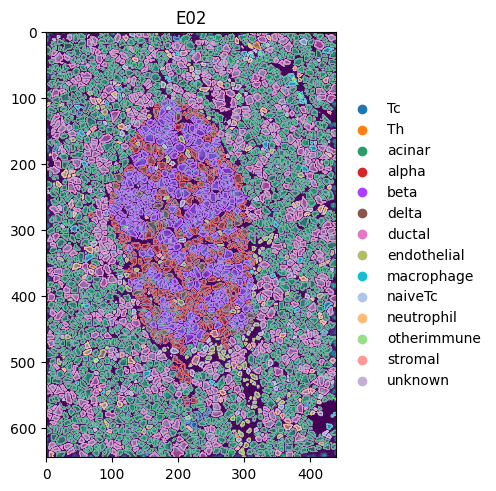

In [12]:
sdata.pl.render_images(channel=['H3']).pl.render_labels(color='cell_type').pl.show(coordinate_systems='E02')